In [22]:
import os
import urllib.request
import json
import pandas as pd
import matplotlib.pyplot as plt
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
from bs4 import BeautifulSoup
import requests
import time

# 한글 폰트 설정

In [ ]:
plt.rcParams['font.family'] = 'Malgun Gothic'  # Windows: 'Malgun Gothic', MacOS: 'AppleGothic', Linux: 'NanumGothic'
plt.rcParams['axes.unicode_minus'] = False     # 마이너스 기호 깨짐 방지

# 네이버 API 키 설정

In [24]:
client_id = 'YaKyDrFyIZDRfIiRAwBj'
client_secret = 'hknmr5WHGm'

# KoBERT Fine-tuned 모델 로드

In [25]:
def load_sentiment_model():
    model_name = "beomi/kcbert-base"  # KoBERT 기반 공개 모델
    tokenizer = AutoTokenizer.from_pretrained(model_name, cache_dir="./model_cache")
    model = AutoModelForSequenceClassification.from_pretrained(
        model_name, num_labels=3, cache_dir="./model_cache"
    )
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    return tokenizer, model, device

# 뉴스 API 데이터  수집 함수

In [26]:
def get_news_data(client_id, client_secret, query, display=10, start=1, sort='date'):
    enc_text = urllib.parse.quote(query)
    url = f"https://openapi.naver.com/v1/search/news?query={enc_text}&display={display}&start={start}&sort={sort}"
    
    request = urllib.request.Request(url)
    request.add_header("X-Naver-Client-Id", client_id)
    request.add_header("X-Naver-Client-Secret", client_secret)
    
    response = urllib.request.urlopen(request)
    rescode = response.getcode()
    
    if rescode == 200:
        response_body = response.read()
        response_json = json.loads(response_body)
        return pd.DataFrame(response_json['items'])
    else:
        print(f"Error Code: {rescode}")
        return pd.DataFrame()


# API 데이터 날짜 필터링 함수 (2024년만 됩니다.)

In [27]:
def filter_by_date(news_data, year):
    news_data['pubDate'] = pd.to_datetime(news_data['pubDate'], errors='coerce')  # 날짜 형식으로 변환
    news_data = news_data.dropna(subset=['pubDate'])  # 유효한 날짜가 없는 데이터 제거
    news_data = news_data[news_data['pubDate'].dt.year == year]  # 특정 연도 필터링
    news_data['Date'] = news_data['pubDate'].dt.strftime('%Y-%m-%d')  # YYYY-MM-DD 형식 생성
    return news_data

# API를 가져와서 데이터를 부정 중립 긍정으로 분류

In [28]:
def batch_analyze_sentiments(texts, tokenizer, model, device):
    inputs = tokenizer(
        texts,
        return_tensors="pt",
        truncation=True,
        max_length=300,  # 입력 텍스트를 300 토큰으로 제한
        padding=True
    ).to(device)
    with torch.no_grad():
        outputs = model(**inputs)
    logits = outputs.logits
    sentiments = torch.argmax(logits, dim=-1).tolist()
    sentiment_map = {0: "부정", 1: "중립", 2: "긍정"}
    return [sentiment_map[s] for s in sentiments]

# 크롤링 데이터를 가져오는 함수

def crawl_article(url):
    response = requests.get(url)
    print(response.text)  # HTML 내용을 출력하여 구조 확인
    soup = BeautifulSoup(response.text, 'html.parser')
    
    title = soup.find('h1')
    body = soup.find('div', {'class': 'article'})
    
    if title:
        title_text = title.get_text(strip=True)
    else:
        title_text = "제목을 찾을 수 없습니다."
    
    if body:
        body_text = body.get_text(strip=True)
    else:
        body_text = "본문을 찾을 수 없습니다."
    
    return {"title": title_text, "body": body_text}

# 시각화 함수

def plot_sentiment_distribution(sentiment_count, query):
    sentiment_count.plot(kind='bar', stacked=True, figsize=(12, 6), colormap='coolwarm')
    plt.title(f"뉴스 검색어 '{query}' 날짜별 감정 분석 결과")
    plt.xlabel("날짜")
    plt.ylabel("감정 건수")
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()

# API + 크롤링 데이터를 = kobert에 넣어서 최종적으로 탐색

In [31]:
# 메인 함수
def main():
    query = "비트코인"
    display = 100  # 한 번에 가져올 뉴스 데이터 수
    num_requests = 3  # 가져올 페이지 수 (100개씩)
    year = 2024  # 필터링할 연도
    sort = "date"  # 날짜순 정렬
    crawl_url = "https://www.g-enews.com/ko-kr/news/article/news_all/202312031530096281e7e8286d56_1/article.html"

    # KoBERT 모델 로드
    tokenizer, model, device = load_sentiment_model()

    # 뉴스 데이터 수집
    result_all = pd.DataFrame()
    for i in range(num_requests):
        start = 1 + display * i
        result = get_news_data(client_id, client_secret, query, display, start, sort)
        result_all = pd.concat([result_all, result])
        time.sleep(1)  # API 호출 간 간격 추가

    # 크롤링 데이터 추가
    crawled_article = crawl_article(crawl_url)
    crawled_df = pd.DataFrame([crawled_article])

    # 날짜 필터링
    result_all = filter_by_date(result_all, year)

    if result_all.empty and crawled_df.empty:
        print(f"{year}년의 뉴스 데이터가 없습니다.")
        return

    # 감정 분석 수행
    all_descriptions = (
        result_all['description'].str.replace('<b>', '').str.replace('</b>', '').tolist()
        + crawled_df['body'].tolist()
    )
    sentiments = batch_analyze_sentiments(all_descriptions, tokenizer, model, device)

    # 감정 분석 결과 결합
    result_all['Sentiment'] = sentiments[:len(result_all)]
    crawled_df['Sentiment'] = sentiments[len(result_all):]

    # 날짜 및 감정별 집계
    sentiment_count = result_all.groupby(['Date', 'Sentiment']).size().unstack(fill_value=0)

    # 결과 출력
    print(sentiment_count)
    print(crawled_df[['title', 'Sentiment']])

    # 그래프 생성
    plot_sentiment_distribution(sentiment_count, query)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at beomi/kcbert-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


<!doctype html>
<html lang="ko">
<head>
<meta charset="utf-8">
<meta http-equiv="imagetoolbar" content="no">
<meta http-equiv="X-UA-Compatible" content="IE=edge,chrome=1">
<meta name="format-detection" content="telephone=no">
<meta name="naver-site-verification" content="895f0cfa66a9786a2d193bafadd9f7d8c422a4cb"/>
<meta name="google-site-verification" content="UWOZ-iJYSt9PlmqwgtSo1J21OOZnzKcKlQRNLdScYMg" />
<meta name="google-site-verification" content="JIQHHcpAMKJGQnPHGtke2guVWUR2XpZsqUTWHpic1lU" />
<meta http-equiv="cache-control" content="No-Cache" /> 
<meta http-equiv="pragma" content="No-Cache" />
<meta name="referrer" content="no-referrer-when-downgrade">
<link rel="shortcut icon" type="image/x-icon" href="/favicon.ico" />

<title>일론 머스크 관련 ‘밈 토큰’ 급등…가상화폐 생태계 흔들까 - 글로벌이코노믹</title>
<meta name="keywords" content="일론 머스크 관련 ‘밈 토큰’ 급등…가상화폐 생태계 흔들까"/>
<meta name="news_keywords" content="일론 머스크 관련 ‘밈 토큰’ 급등…가상화폐 생태계 흔들까"/>
<meta name="description" content="테슬라 최고경영자(CEO)이자 소셜미디어 X(구 트위

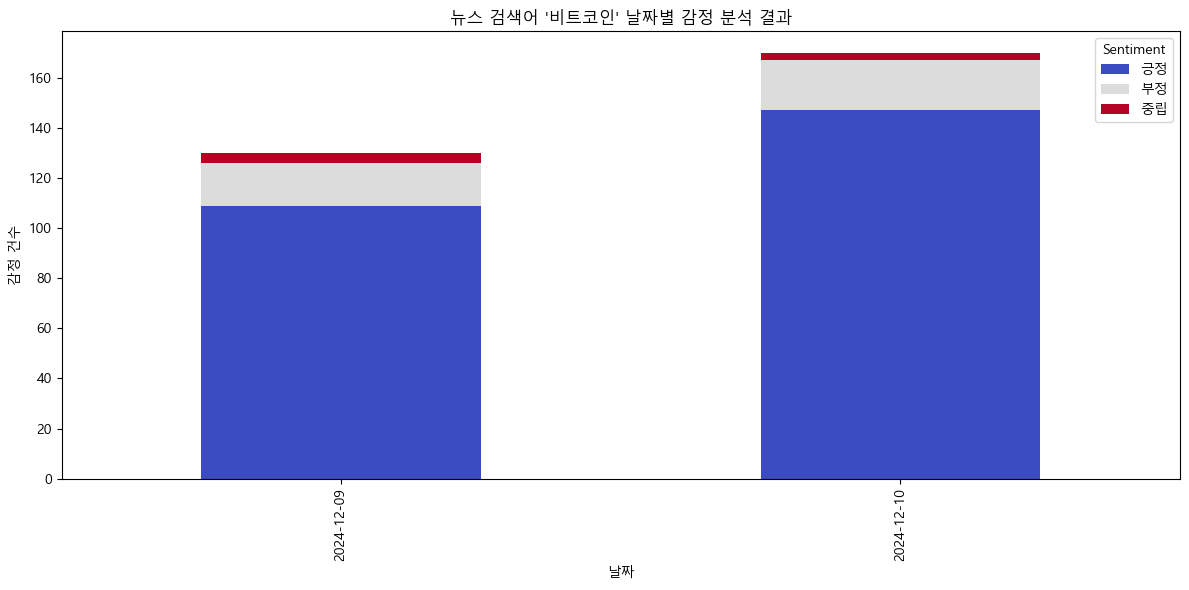

In [32]:
if __name__ == "__main__":
    main()